In [1]:
import yolo_modified as yolo
import cv2
import numpy as np
import os

Using TensorFlow backend.


In [2]:
model = yolo.YOLO()

logs/000/Jason_trained_weights_final.h5 model, anchors, and classes loaded.


In [3]:
label_path = "model_data/MIR_test.txt"

In [4]:
with open(label_path) as f:
    content = f.readlines()
ground_truth = {i.split(' ')[0]:np.array([[int(a) for a in aa[0:4]] 
                                for aa in [x.split(',') for x in i.split(' ')[1:]]]) for i in content}

In [15]:
for path in ground_truth:
    frame = cv2.imread(path)
    for box in ground_truth[path]:
        frame = cv2.circle(frame,(box[0],box[1]), 30, (0,0,255), -1)
        frame = cv2.circle(frame,(box[2],box[3]), 30, (0,0,255), -1)
    new_path = "check/"+path
    cv2.imwrite(new_path,frame)
        

In [7]:
img_path = "PPMI_/test/Play_Guitar_009.jpg"

In [8]:
frame = cv2.imread(img_path)

(416, 416, 3)
Found 1 boxes for img
guitar 0.65 (61, 176) (493, 346)


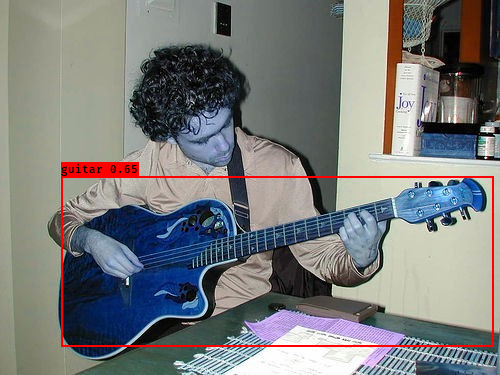

In [9]:
frame = cv2.imread(img_path)
image = yolo.Image.fromarray(frame)
out_boxes, out_scores, out_classes = model.detect_image_rectang(image)
image = model.draw_rect(image,out_boxes,out_scores,out_classes)
image

In [10]:
output = out_boxes[0]

In [13]:
[output[1],output[0],output[3],output[2]]

[60.96214, 176.05862, 493.19302, 345.839]

In [11]:
gt = ground_truth["PPMI_/test/Play_Guitar_009.jpg"][0]

In [12]:
gt

array([ 51, 176, 485, 363])

In [62]:
output_ad = [output[1],output[0],output[3],output[2]]

In [63]:
def bb_intersection_over_union(boxA, boxB):
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    # compute the area of intersection rectangle
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)

    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = interArea / float(boxAArea + boxBArea - interArea)

    # return the intersection over union value
    return iou